## Exploracion Inicial

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

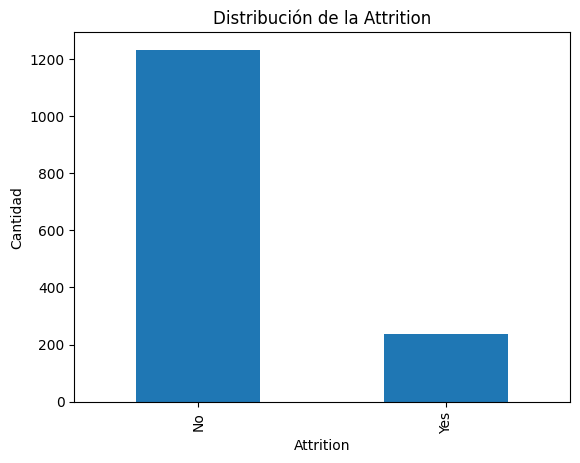

In [13]:

import pandas as pd
import matplotlib.pyplot as plt

# Importamos el dataset
df = pd.read_csv('employee-attrition-dataset.csv')
df.head()

print(df.isna().sum().sort_values())  # Verifico valores nulos en cada columna
print(df.dtypes) # Verifico los tipos de datos de cada columna
print(df.describe())  # Resumen estadístico de las columnas numéricas
print(df['Attrition'].value_counts(normalize=True))

# Vislualización de la distribución de la variable objetivo 'Attrition'
df['Attrition'].value_counts().plot(kind='bar')
plt.title('Distribución de la Attrition')
plt.xlabel('Attrition')
plt.ylabel('Cantidad')
plt.show()


## Preprocesamiento

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separamos features y target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Convertimos la variable objetivo a numérica
y_encoded = np.where(y == 'Yes', 1, 0)

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Convertimos las columnas categóricas a numericas usando OneHotEncoder y estandarizamos las numericas usando StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Aplicamos el preprocesamiento, evitando data leakage
X_train_standardized = preprocessor.fit_transform(X_train)
X_test_standardized = preprocessor.transform(X_test)

## Modelado

Confusion Matrix for Logistic Regression:
[[292  88]
 [ 24  37]]

Confusion Matrix for K-Nearest Neighbors:
[[371   9]
 [ 55   6]]

Confusion Matrix for Random Forest:
[[376   4]
 [ 56   5]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       380
           1       0.30      0.61      0.40        61

    accuracy                           0.75       441
   macro avg       0.61      0.69      0.62       441
weighted avg       0.84      0.75      0.78       441


Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       380
           1       0.40      0.10      0.16        61

    accuracy                           0.85       441
   macro avg       0.64      0.54      0.54       441
weighted avg       0.81      0.85      0.82       441


Classification Report for Random Forest:
              pre

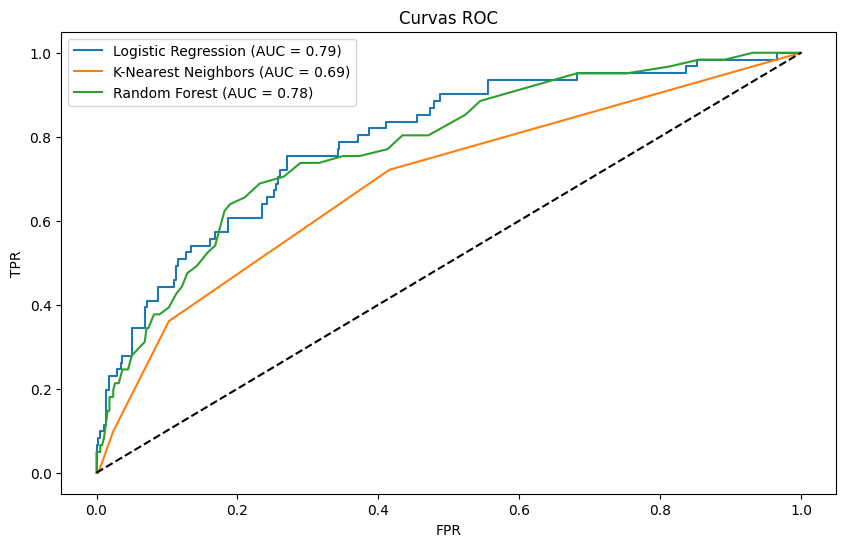

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Inicializamos los modelos
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

models = {
    'Logistic Regression': logistic_model,
    'K-Nearest Neighbors': knn_model,
    'Random Forest': rf_model
}

# Entrenamos los modelos
for model in models.values():
    model.fit(X_train_standardized, y_train)

# Evaluamos los modelos
predictions = {}
for name, model in models.items():
    y_pred = model.predict(X_test_standardized)
    predictions[name] = y_pred

# Calculamos las métricas
metrics = {}
for name, y_pred in predictions.items():
    metrics[name] = {
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'roc_auc_score': roc_auc_score(y_test, model.predict_proba(X_test_standardized)[:, 1])
    }

# Mostramos las métricas 
# Mostramos las matrices de confusión
for name, metric in metrics.items():
    print(f"Confusion Matrix for {name}:")
    print(metric['confusion_matrix'])
    print()

# Mostramos los reportes de clasificación
for name, metric in metrics.items():
    print(f"Classification Report for {name}:")
    print(metric['classification_report'])
    print()

# Mostramos los scores ROC AUC
for name, metric in metrics.items():
    print(f"ROC AUC Score for {name}: {metric['roc_auc_score']:.4f}")

# Visualizamos las curvas ROC
plt.figure(figsize=(10, 6))
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_standardized)[:, 1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test_standardized)[:, 1]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC')
plt.legend()
plt.show()

## Ajustamos hiperparametros para Logistic Regression

Elijo la Regresion Logistica debido a que tiene un recall mas alto que los otros modelos, lo que es importante en este problema ya que queremos identificar todos los cassos de attrition posibles.

In [ ]:
from sklearn.model_selection import GridSearchCV

logistic_model = models['Logistic Regression']

# Definir el espacio de hiperparámetros para LogisticRegression
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1],  # Más valores para regularización
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    scoring='recall',  # Maximizar el recall
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_standardized, y_train)

best_model = grid_search.best_estimator_

# Paso 1: Obtener nombres de columnas transformadas
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_features])

# Paso 2: Obtener coeficientes del mejor modelo
coefs = best_model.coef_[0]  # Es un array de 1D

# Paso 3: Combinar en un DataFrame y ordenar
importance = pd.DataFrame({
    'feature': all_features,
    'coefficient': coefs,
    'abs_value': np.abs(coefs)
}).sort_values(by='abs_value', ascending=False)

# Mostrar las 5 más influyentes
print(importance.head(5))

y_pred = best_model.predict(X_test_standardized)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor recall promedio en validación cruzada:", grid_search.best_score_)

               feature  coefficient  abs_value
19   TotalWorkingYears    -0.012132   0.012132
23  YearsInCurrentRole    -0.011559   0.011559
0                  Age    -0.011138   0.011138
9             JobLevel    -0.011024   0.011024
11       MonthlyIncome    -0.010398   0.010398
Mejores hiperparámetros: {'C': 0.0001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Mejor recall promedio en validación cruzada: 0.783968253968254
